# SIIM ACR Pneumothorax Segmentation

[Competition link](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation)  
This is project to try to segment Pneumothorax through X ray image.  
My algorithm is using U-net plus plus with efficientnet backbone.  
Detail:
* Unet with customize plus structure
* Efficient net B4 backbone
* CBAM in decoder
* Image augment:  Contrast, Gamma, Brightness, ElasticTransform, GridDistortion, OpticalDistortion
* SWA
* cos learning rate schedual with Adam optimizer
* TTA with horizenflip
* Dice loss/ IOU metrix

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split,StratifiedKFold
import os
import keras
from keras import backend as K
from keras.utils import Sequence
from PIL import Image
import cv2
import albumentations
import segmentation_models as sm
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D , MaxPool2D, UpSampling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization, Multiply
from keras.layers import LeakyReLU, Dense, GlobalAveragePooling2D, Lambda, GlobalMaxPooling2D
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, add, multiply
from keras.layers.merge import concatenate, add
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from classification_models import Classifiers
from tqdm import tqdm_notebook
import keras.callbacks as callbacks
import tensorflow as tf
import seaborn as sns
import shutil

from mask_functions import mask2rle

Using TensorFlow backend.
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\a2720\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Data process
Original data is dcm data, which original image resolution is 1024 * 1024  
which is too big data volume to my device, so I choice data with 128 * 128 size from kaggle

In [2]:
epochs = 80
batch_size = 26
swa_nb = epochs-5

lr = 0.001
image_size,h,w = 128,128,128
channels = 3


train_root_dir = './results/train/'
mask_root_dir = './results/masks/'
test_root_dir = './results/test/'


model_name = './Unetplusplusplus_cbam'

Check the image and it's mask

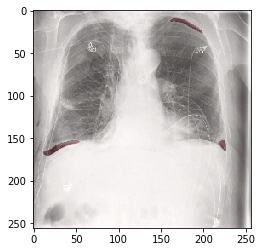

In [3]:
im_path = './results/train/1.2.276.0.7230010.3.1.4.8323329.10011.1517875220.977487.png'
mk_path = im_path.replace('train','masks')

im = Image.open(im_path)
im = np.uint8(im)

mk = Image.open(mk_path)
mk = np.uint8(mk)

plt.imshow(im,cmap = 'gray')
plt.imshow(mk,alpha = 0.3,cmap='Reds')

## EDA
Check the mask coverage in one image.  
As we can see, the coverage ratio is small.  
Thus, using BCE may not be a good choice.  
Therefore, I have choice DICE loss

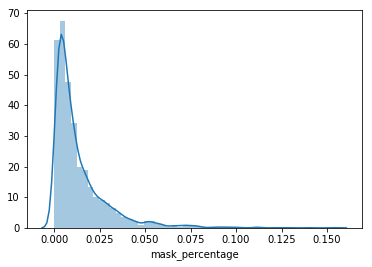

In [4]:
all_mk = glob.glob(mask_root_dir+'*')
check = pd.DataFrame()
check['file_names'] = all_mk
check['mask_percentage'] = 0
check.set_index('file_names',inplace=True)
for item in all_mk:
    check.loc[item,'mask_percentage'] = np.array(Image.open(item)).sum()/(256*256*255)

check.reset_index(inplace=True)
check['labels'] = 0
check.loc[check.mask_percentage>0,'labels']=1
check.head(10)

sns.distplot(check.loc[check.mask_percentage>0,'mask_percentage'])

In [5]:
all_train = glob.glob(train_root_dir+'*')
total_samples = len(all_train)

train_file, val_file = train_test_split(all_train,stratify=check.labels,test_size=0.1)

print('No. of train files:', len(train_file))
print('No. of val files:', len(val_file))

mask_train_file = [fn.replace('train','masks') for fn in train_file]    
mask_val_file = [fn.replace('train','masks') for fn in val_file]

No. of train files: 10842
No. of val files: 1205


In [6]:
all_train[0]

'./results/train\\1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.png'

In [7]:
TRAIN_DIR = './im_train'
if not os.path.exists(TRAIN_DIR):
    os.mkdir(TRAIN_DIR)
    for full_fn in train_file:
        fn = full_fn.split('\\')[-1]
        dist = os.path.join(TRAIN_DIR,fn)
        if not os.path.exists(dist):
            shutil.copyfile(full_fn,dist)
    
TRAIN_MASK_DIR = './im_mask_train'
if not os.path.exists(TRAIN_MASK_DIR):
    os.mkdir(TRAIN_MASK_DIR)
    for full_fn in mask_train_file:
        fn = full_fn.split('\\')[-1]
        dist = os.path.join(TRAIN_MASK_DIR,fn)
        if not os.path.exists(dist):
            shutil.copyfile(full_fn,dist)
    
VAL_DIR = './im_val'
if not os.path.exists(VAL_DIR):
    os.mkdir(VAL_DIR)
    for full_fn in val_file:
        fn = full_fn.split('\\')[-1]
        dist = os.path.join(VAL_DIR,fn)
        if not os.path.exists(dist):
            shutil.copyfile(full_fn,dist)
    
VAL_MASK_DIR = './im_mask_val'
if not os.path.exists(VAL_MASK_DIR):
    os.mkdir(VAL_MASK_DIR)
    for full_fn in mask_val_file:
        fn = full_fn.split('\\')[-1]
        dist = os.path.join(VAL_MASK_DIR,fn)
        if not os.path.exists(dist):    
            shutil.copyfile(full_fn,dist)

## Datagenerator

the output image format is uint8[0~255].  
mask is also uint8[0~1]  

In [8]:
class Datagen(Sequence):
    def __init__(self, train_dir = TRAIN_DIR, mask_dir = TRAIN_MASK_DIR, augmentation = None,
                 batch_size = batch_size, shuffle = True, image_size = image_size, channels = channels):
        self.train_dir = train_dir
        self.train_dirs = glob.glob(train_dir+'/*')
        self.mask_dir = mask_dir
        self.augment = augmentation
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.image_size = image_size
        self.channels = channels
        self.on_epoch_end()
        
    def __getitem__(self,index):
        # get the indexes
        indexes = self.indexes[(index)*self.batch_size:min((index+1)*self.batch_size,len(self.train_dirs))]
        
        # list of items
        list_id_items = [self.train_dirs[x] for x in indexes]
        image, mask = self.data_generator(list_id_items)

        if self.augment is None:
            return image, mask
        else:
            images = [] ; masks = [] 
            for x, y in zip(image,mask):
                augment_result = self.augment(image = x, mask = y)
                images.append(augment_result['image'])
                masks.append(augment_result['mask'])
            return np.array(images), np.array(masks)
        
    def __len__(self):
        return int(np.ceil(len(self.train_dirs)/self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.train_dirs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def data_generator(self,list_id_items):
        batch_size = len(list_id_items)
        
        images = np.empty((batch_size, self.image_size, self.image_size, self.channels))
        masks = np.empty((batch_size, self.image_size, self.image_size, 1))
        
        for i , data in enumerate(list_id_items):
            # get source image
            
            im = cv2.resize(np.array(Image.open(data)),(self.image_size,self.image_size))
            
            mk_list = data.replace('im','im_mask')
            mk = cv2.resize(np.array(Image.open(mk_list)),(self.image_size,self.image_size))
            
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)
            
            images[i,] = im
            masks[i]= mk[..., np.newaxis]
            masks[masks>0] = 1.
            
        return np.uint8(images), np.uint8(masks)

### Check data generator

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

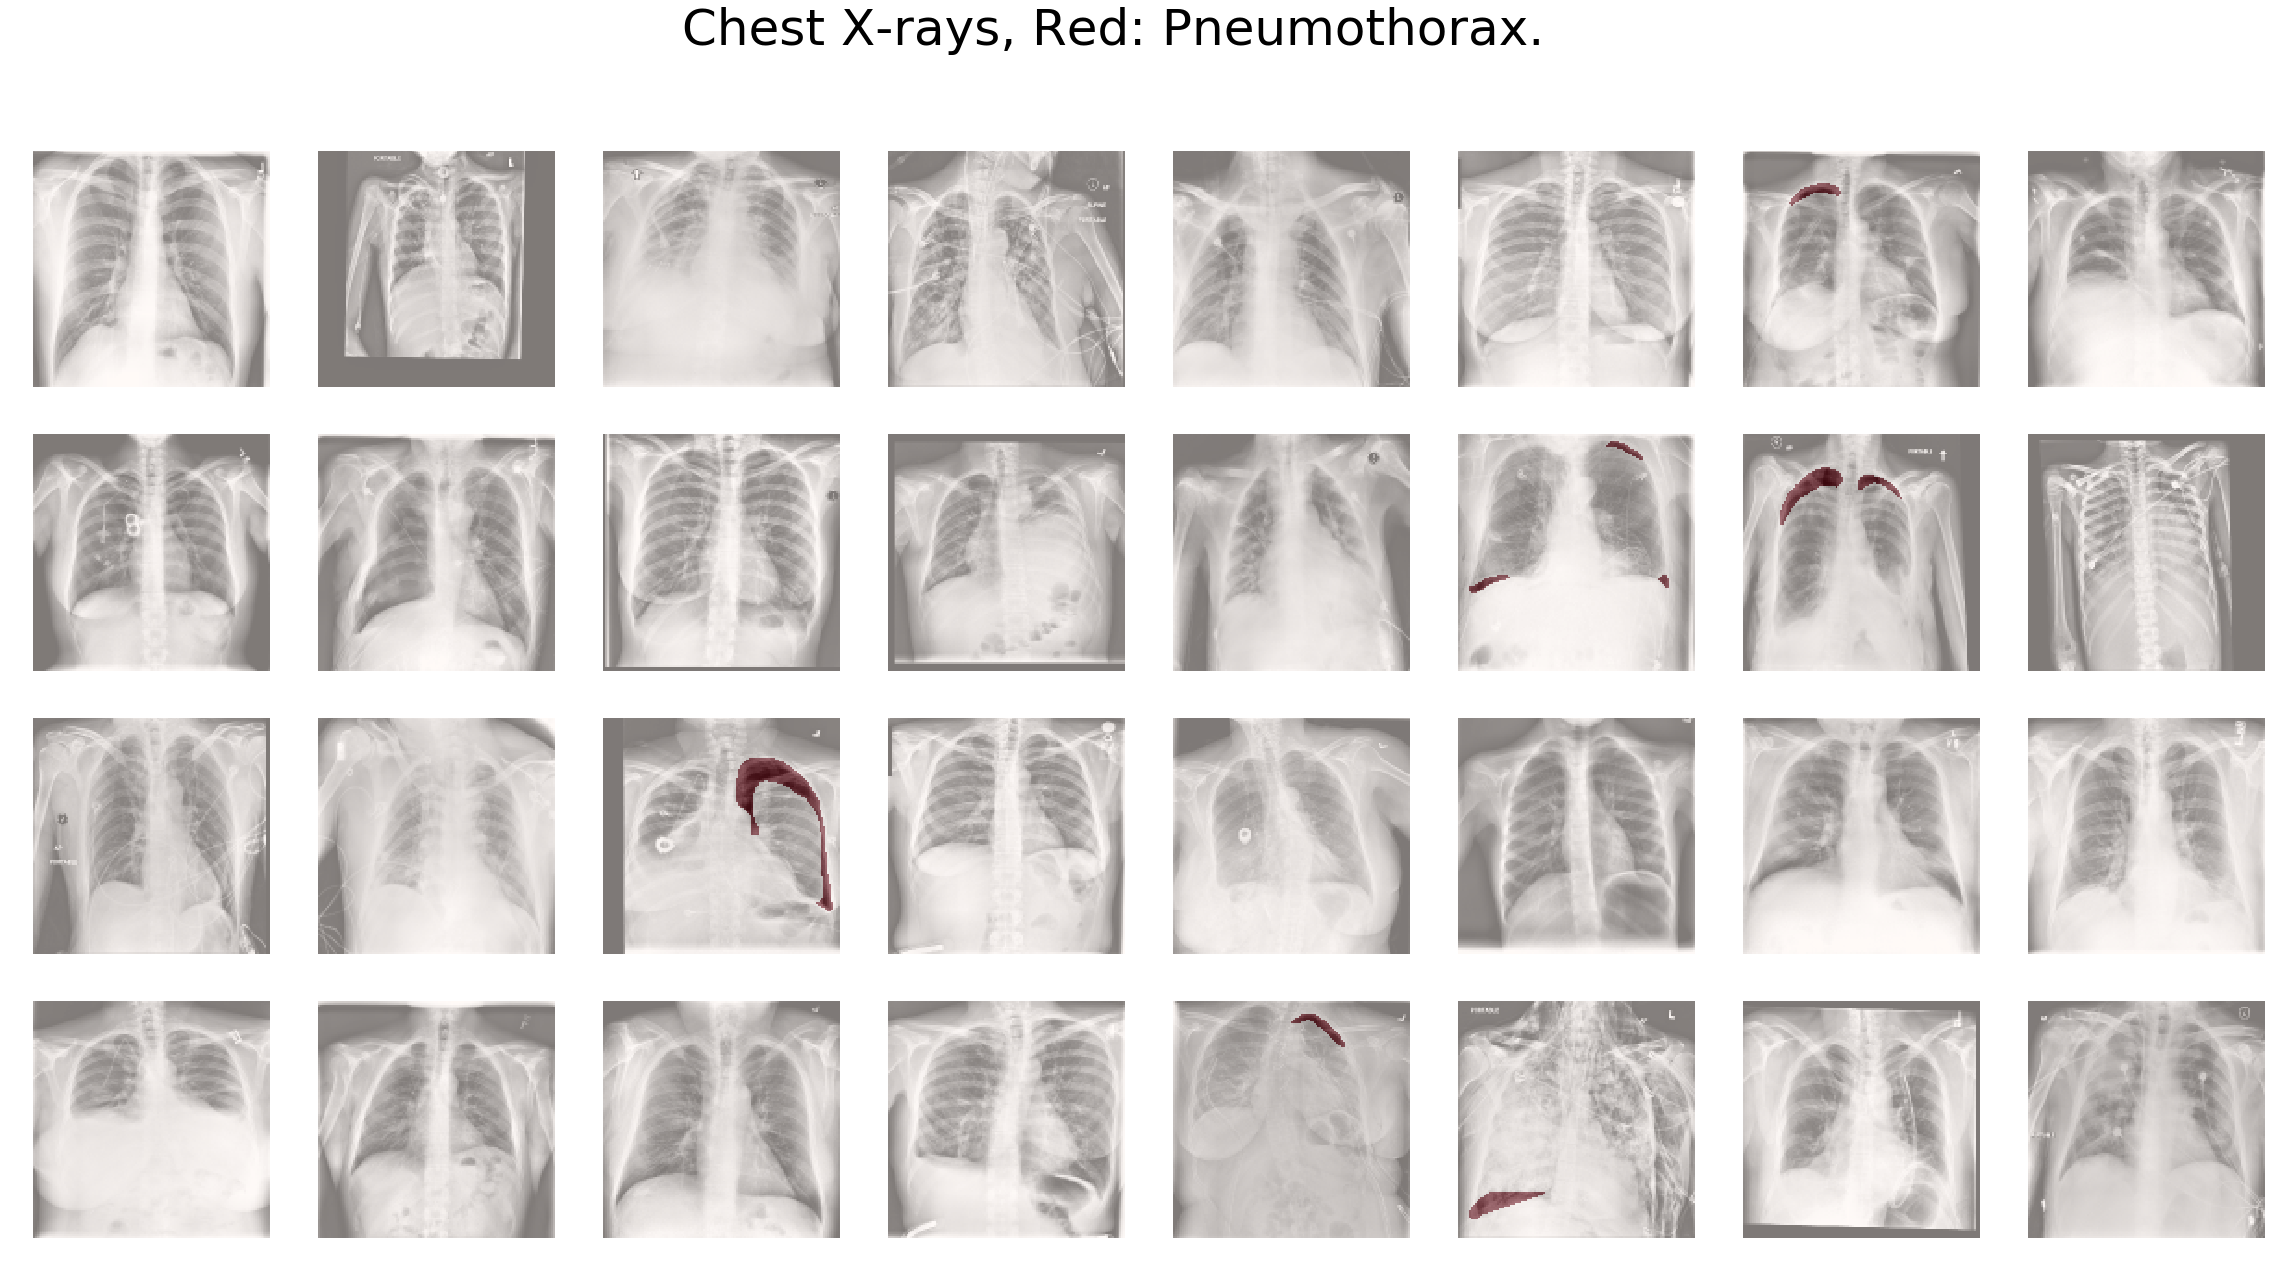

In [9]:
show_img = 32
a = Datagen(batch_size = show_img, shuffle = False)
images, masks = a.__getitem__(0)

fig_height = 4
fig_width = int(show_img/fig_height)
fig, axes = plt.subplots(fig_height,fig_width,figsize=(fig_width*5,fig_height*5))

for i, (im , mk) in enumerate(zip(images,masks)):
    ax = axes[int(i/fig_width),i%fig_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mk.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.",fontsize=50)    

## Image augementation

very useful augmentation module, reference:  
[Document](https://albumentations.readthedocs.io/en/latest/api/augmentations.html)  
[Github](https://github.com/albumentations-team/albumentations)

In [10]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.1),
    OneOf([
        ElasticTransform(alpha=100, sigma=150 * 0.05, alpha_affine=150 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=0.5, shift_limit=0.5),
        ], p=0.2),
    ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

### Check data generator with augmentation

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

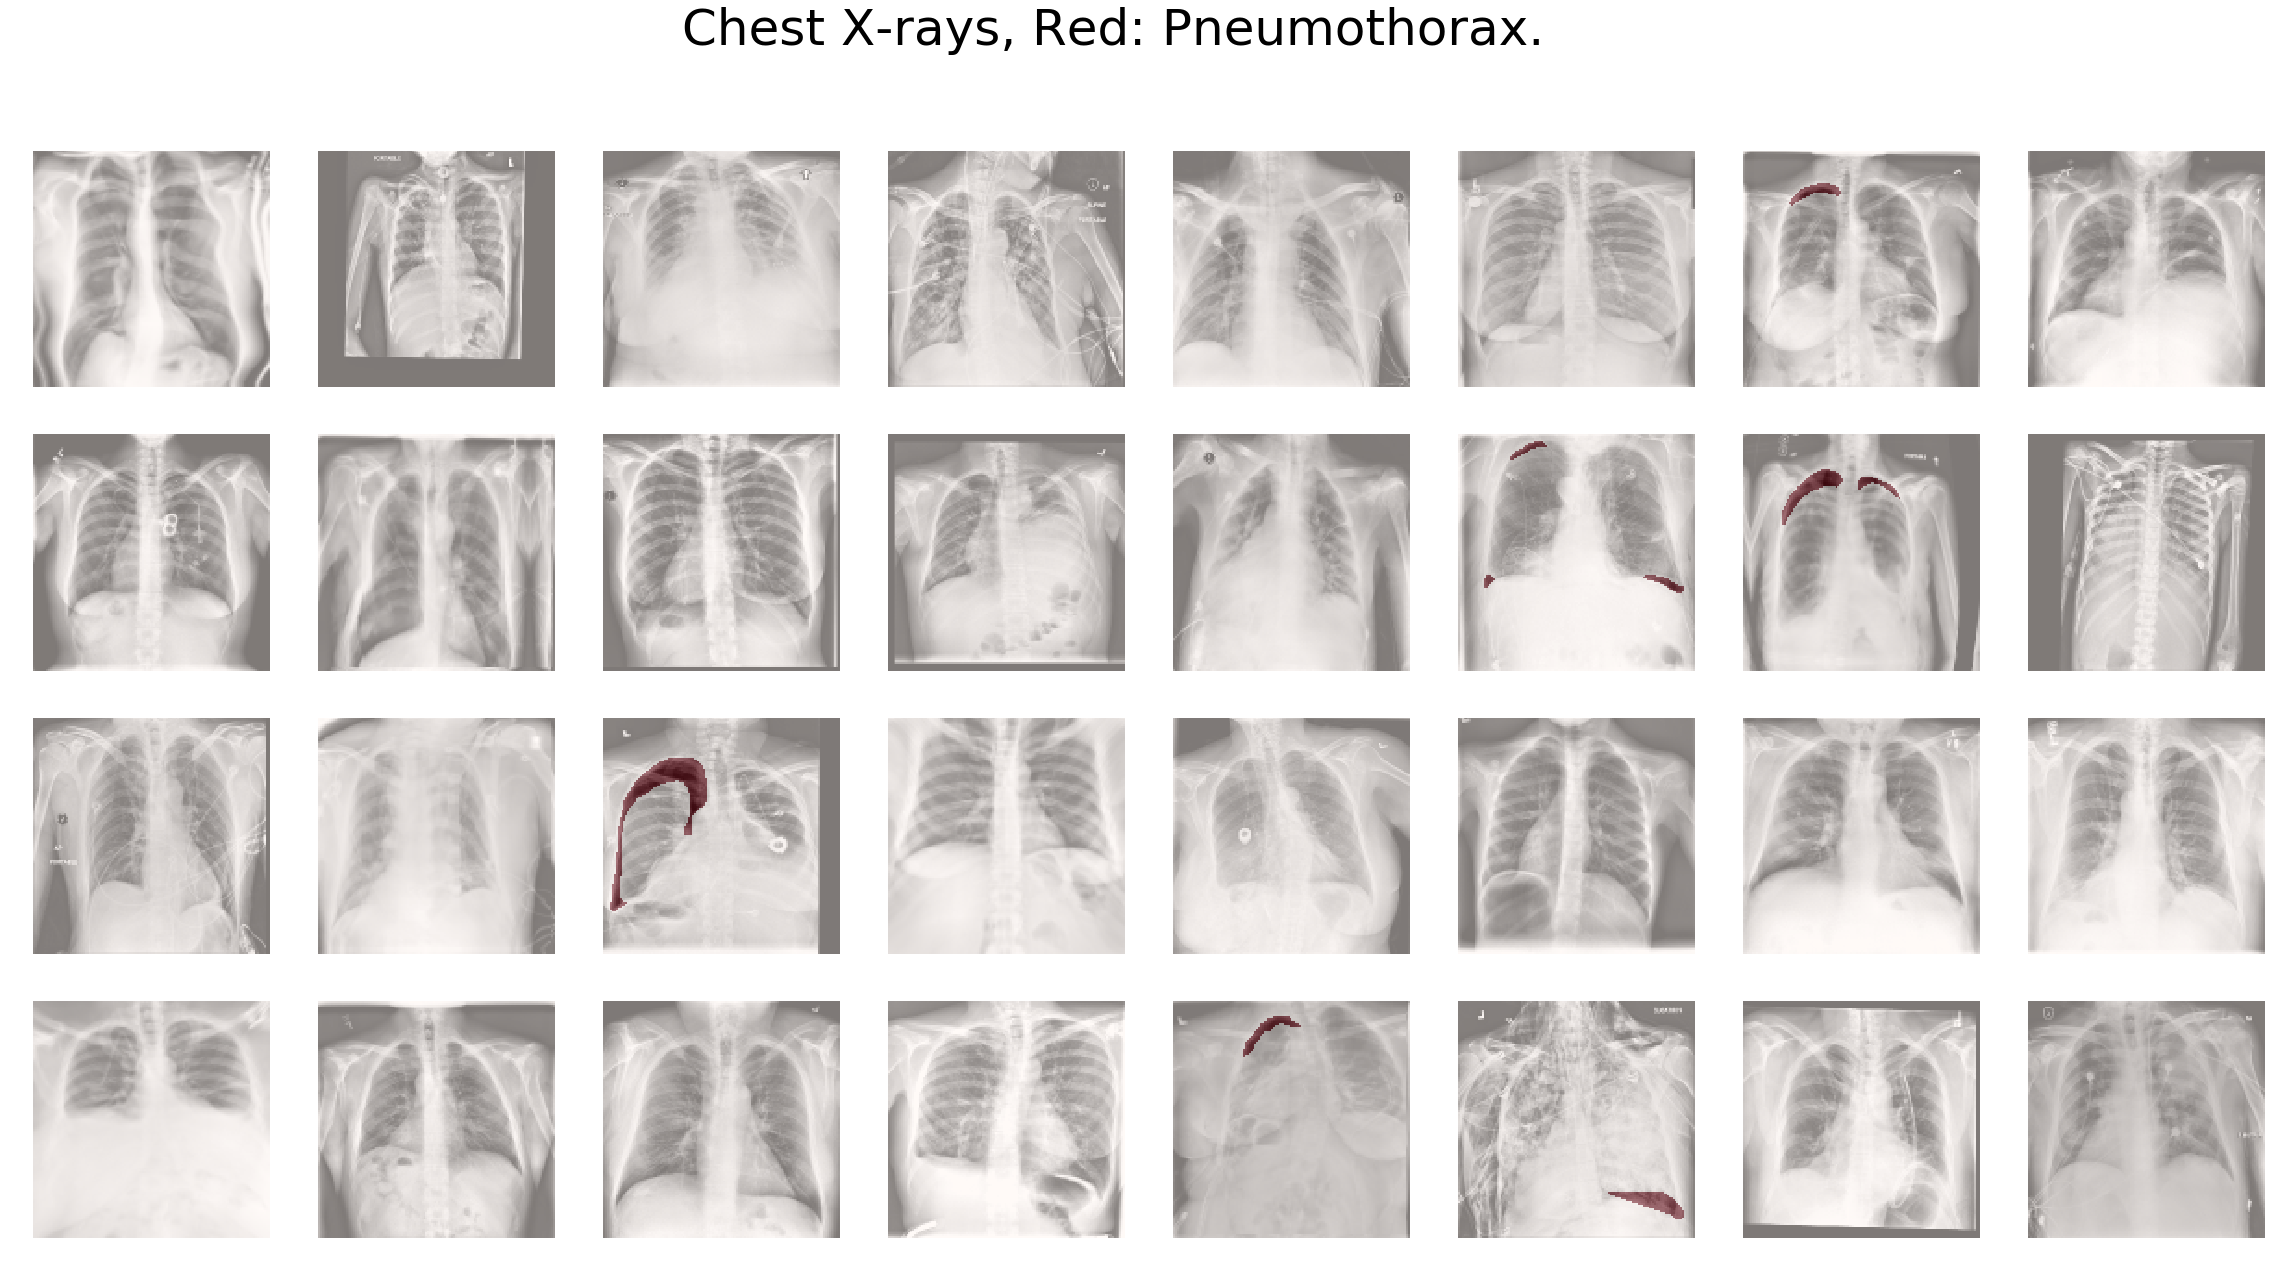

In [11]:
show_img = 32
a = Datagen(batch_size = show_img,augmentation = AUGMENTATIONS_TRAIN, shuffle = False)
images, masks = a.__getitem__(0)

fig_height = 4
fig_width = int(show_img/fig_height)
fig, axes = plt.subplots(fig_height,fig_width,figsize=(fig_width*5,fig_height*5))

for i, (im , mk) in enumerate(zip(images,masks)):
    ax = axes[int(i/fig_width),i%fig_width]
    ax.imshow(im.squeeze().astype('uint8'), cmap="bone")
    ax.imshow(mk.squeeze().astype('uint8'), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.",fontsize=50)   

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

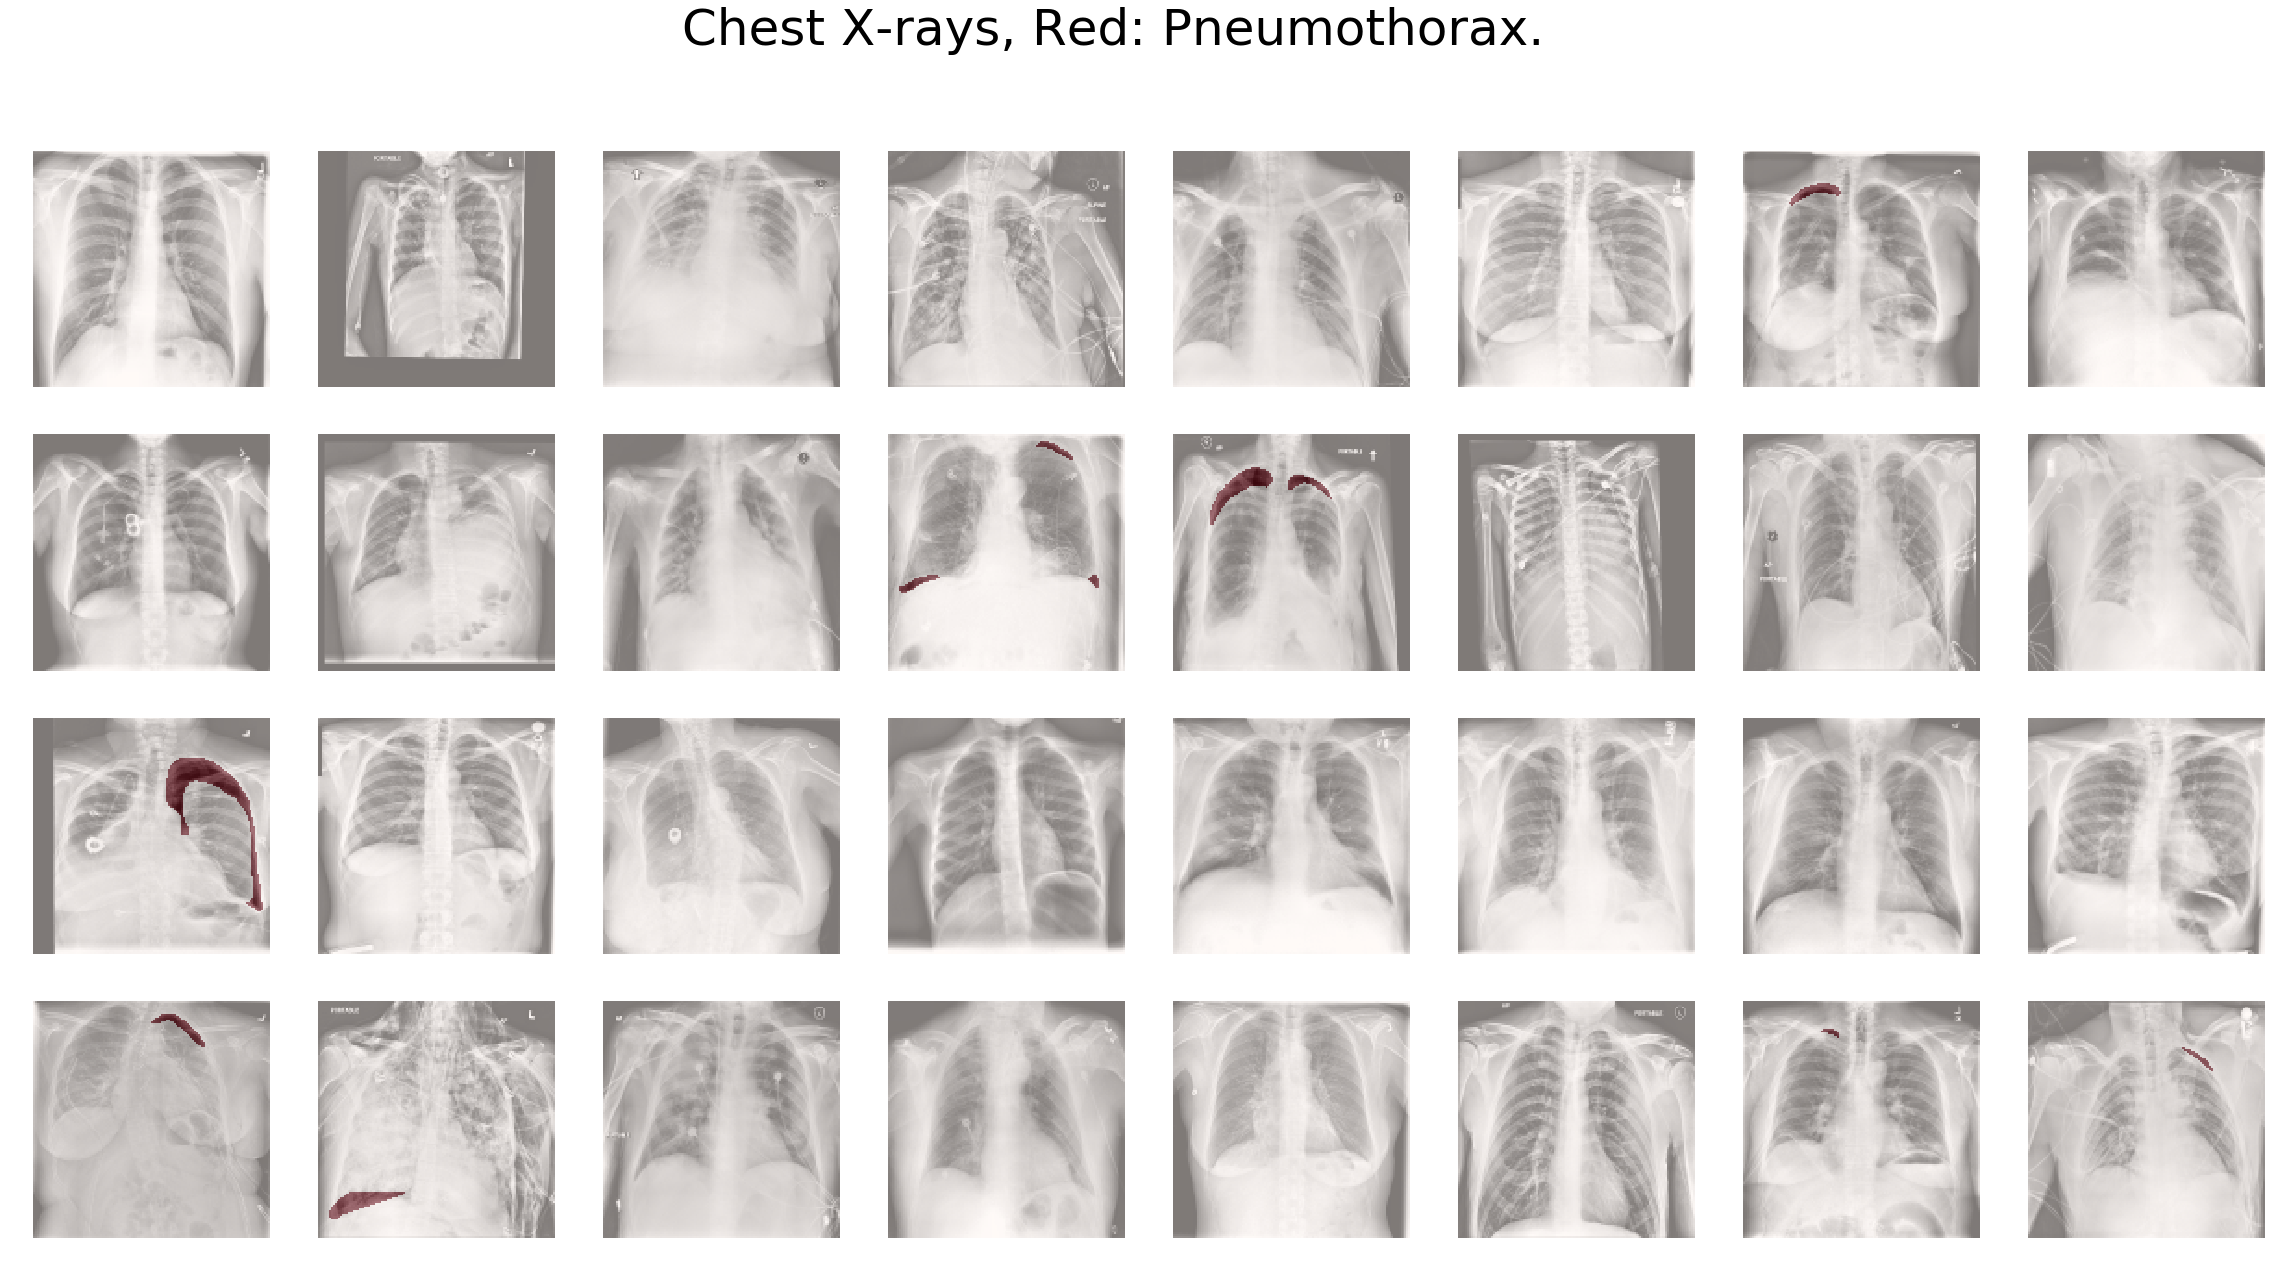

In [12]:
show_img = 32
a = Datagen(train_dir =VAL_DIR , mask_dir =VAL_MASK_DIR, batch_size = show_img,
            augmentation = AUGMENTATIONS_TEST, shuffle = False)
images, masks = a.__getitem__(0)

fig_height = 4
fig_width = int(show_img/fig_height)
fig, axes = plt.subplots(fig_height,fig_width,figsize=(fig_width*5,fig_height*5))

for i, (im , mk) in enumerate(zip(images,masks)):
    ax = axes[int(i/fig_width),i%fig_width]
    ax.imshow(im.squeeze().astype('uint8'), cmap="bone")
    ax.imshow(mk.squeeze().astype('uint8'), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.",fontsize=50)   

### Evaluate metric

For image segmentation evaluate metric, usually use IOU metric or DICE metric  
For those two difference, in short, IOU takes more penalization when the false case happened.  
And for Kaggle evaluate, which take more penalization on incorrect case.  
Therefore, I choice IOU.  


[DICE vs IOU](https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou)  
[IOU reference](https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow)

In [13]:
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    smooth = 1e-6
    B = B > 0.5
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        '''
        if true == 0:
            metric += (pred == 0)
            continue
        '''
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = (intersection+smooth) / (union+smooth)
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.5)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred], tf.float64)

### DICE loss
DICE loss is calculated  the intersection part divide to the union part.  
Can be seen as 2TP/(2TP+FP+FN)  
[reference](https://blog.csdn.net/m0_37477175/article/details/83004746)

In [14]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

### CNN useful module
CBAM  
[reference](https://www.jianshu.com/p/3e33ab049b4e)  
[Paper](https://arxiv.org/pdf/1807.06521.pdf)  
![](https://imgur.com/xqAUUM4.png)

In [15]:
def cbam_block(cbam_feature, channel, ratio = 4, kernel_size = 7):

    cbam_feature = channel_attention(cbam_feature, channel, ratio)
    cbam_feature = spatial_attention(cbam_feature, kernel_size)
    return cbam_feature

def channel_attention(input_feature, channel, ratio=4):

    shared_layer_one = Dense(channel//ratio, activation='relu')
    shared_layer_two = Dense(channel)

    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = shared_layer_one(max_pool)  
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature,kernel_size):

    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(input_feature)
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(input_feature)

    concat = Concatenate(axis=3)([avg_pool, max_pool])
    
    cbam_feature = Conv2D(filters = 1,
                          kernel_size=kernel_size,
                          strides=1,
                          padding='same',
                          activation='sigmoid',
                          use_bias=False)(concat)

    return multiply([input_feature, cbam_feature])

### Attn Unet module

This is not using in this project, may be it would help for another backbone  
The idea is came from attention network, to enhance spatial signal  
[Paper](https://arxiv.org/abs/1804.03999) 
![](https://i.imgur.com/ql1U4gp.png)

In [16]:
def cbam_convolution_block(x, filters, size=(3,3), strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = cbam_block(x,filters)
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = cbam_block(x,filters)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = BatchNormalization()(blockInput)
    x = LeakyReLU(alpha=0.1)(x)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

def attn_block(signal,blockInput):
    signal_shape = K.int_shape(signal)
    blockInput_shape = K.int_shape(blockInput)
    
    #signal = Conv2D(signal_shape[3], (1,1), strides=(1,1), padding='same')(signal)
    #signal = BatchNormalization()(signal)
    #signal = LeakyReLU(alpha=0.1)(signal)
    
    signal = Conv2D(blockInput_shape[3], (1,1), strides=(1,1), padding='same')(signal)
    theta_Input = Conv2D(blockInput_shape[3], (2,2), 
                         strides=(blockInput_shape[1]//signal_shape[1],blockInput_shape[2]//signal_shape[2]), 
                         padding='same')(blockInput)
    
    Add_s_t = Add()([theta_Input, signal])
    Add_s_t = BatchNormalization()(Add_s_t)
    Add_s_t = Activation('relu')(Add_s_t)
    Add_s_t = Conv2D(1, (1,1), strides=(1,1), padding='same')(Add_s_t)
    Add_s_t = BatchNormalization()(Add_s_t)
    Add_s_t = Activation('sigmoid')(Add_s_t)
    
    Add_s_t = UpSampling2D(size=(blockInput_shape[1]//signal_shape[1],blockInput_shape[2]//signal_shape[2]))(Add_s_t)
    
    OutputL = Multiply()([blockInput,Add_s_t])
    
    return OutputL

## Unet plus plus
I have try several structure and backbone  
best socore is like my summury at first mention
Unet with customize structure  
* Efficientnet backbone [reference](http://proceedings.mlr.press/v97/tan19a/tan19a.pdf)
* Unet plus plus [reference](https://arxiv.org/pdf/1807.10165.pdf)  
![](https://imgur.com/osGJfqD.png)

In [17]:
ResNet50, preprocess_input = Classifiers.get('resnet50')
check = ResNet50((128,128,3), weights='imagenet',include_top=False)
print(check.get_layer('stage2_unit1_relu1').output)
print(check.get_layer('relu0').output)

Instructions for updating:
Colocations handled automatically by placer.
Tensor("stage2_unit1_relu1/Relu:0", shape=(?, 32, 32, 256), dtype=float32)
Tensor("relu0/Relu:0", shape=(?, 64, 64, 64), dtype=float32)


In [18]:
def UResnet50(input_shape=(None, None, 3),dropout_rate=0.0):
    
    ResNet50, preprocess_input = Classifiers.get('resnet50')
    backbone = ResNet50(input_shape, weights='imagenet',include_top=False)
    
    input = backbone.input
    start_neurons = 16

    conv4 = backbone.get_layer('stage4_unit1_relu1').output
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = cbam_convolution_block(convm,start_neurons * 32)


    
    #convm = backbone.get_layer('relu1').output
    Atten_conv4 = attn_block(convm,conv4)
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([Atten_conv4, deconv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = cbam_convolution_block(uconv4,start_neurons * 16)

    
    conv3 = backbone.get_layer('stage3_unit1_relu1').output
    Atten_conv3 = attn_block(uconv4,conv3)
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([Atten_conv3,deconv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)  
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = cbam_convolution_block(uconv3,start_neurons * 8)


    conv2 = backbone.get_layer('stage2_unit1_relu1').output
    Atten_conv2 = attn_block(uconv3,conv2)
    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([Atten_conv2,deconv2]) 
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = cbam_convolution_block(uconv2,start_neurons * 4)

    conv1 = backbone.get_layer('relu0').output
    Atten_conv1 = attn_block(uconv2,conv1)
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([Atten_conv1,deconv1]) 
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = cbam_convolution_block(uconv1,start_neurons * 2)

    
    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = cbam_convolution_block(uconv0,start_neurons * 1)

    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [19]:
def UResnet50plusplus(input_shape=(None, None, 3),dropout_rate=0.0):
    
    ResNet50, preprocess_input = Classifiers.get('resnet50')
    backbone = ResNet50(input_shape, weights='imagenet',include_top=False)
    
    input = backbone.input
    start_neurons = 16
    
    
    #0,0
    conv1 = backbone.get_layer('relu0').output
    
    #1,0
    conv2 = backbone.get_layer('stage2_unit1_relu1').output
    
    #2,0
    conv3 = backbone.get_layer('stage3_unit1_relu1').output
      
    # 3,0
    conv4 = backbone.get_layer('stage4_unit1_relu1').output
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
    # 4,0
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same")(pool4)
    convm = cbam_convolution_block(convm,start_neurons * 32)

    # 3,1
    #Atten_conv4 = attn_block(convm,conv4)
    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([conv4, deconv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = cbam_convolution_block(uconv4,start_neurons * 16)
    
    # 2,1
    upconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(conv4)
    upconv4 = concatenate([conv3, upconv4])
    upconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(upconv4)
    
    
    # 2,2
    #Atten_conv3 = attn_block(uconv4,conv3)
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([conv3,upconv4,deconv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)  
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = cbam_convolution_block(uconv3,start_neurons * 8)

    
    # 1,1
    upconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(conv3)
    upconv3 = concatenate([conv2, upconv3])
    upconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(upconv3)    
    
    # 1,2
    upconv4_2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(upconv4)
    upconv4_2 = concatenate([conv2, upconv3, upconv4_2])
    upconv4_2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(upconv4_2)    
    
    # 1,3
    #Atten_conv2 = attn_block(uconv3,conv2)
    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([conv2, upconv3, upconv4_2,deconv2]) 
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = cbam_convolution_block(uconv2,start_neurons * 4)
    
    
    # 0,1
    upconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(conv2)
    upconv2 = concatenate([conv1, upconv2])
    upconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(upconv2)    
    
    # 0,2
    upconv3_2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(upconv3)
    upconv3_2 = concatenate([conv1, upconv2, upconv3_2])
    upconv3_2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(upconv3_2)    
    
    # 0,3
    upconv4_3 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(upconv4_2)
    upconv4_3 = concatenate([conv1, upconv2, upconv3_2, upconv4_3])
    upconv4_3 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(upconv4_3)    
    
    # 0,4
    #Atten_conv1 = attn_block(uconv2,conv1)
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([conv1, upconv2, upconv3_2, upconv4_3,deconv1]) 
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = cbam_convolution_block(uconv1,start_neurons * 2)

    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = cbam_convolution_block(uconv0,start_neurons * 1)

    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [20]:
from efficientnet import EfficientNetB4


def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    start_neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
     # Middle
    convm = Conv2D(start_neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = cbam_convolution_block(convm,start_neurons * 32)
    convm = cbam_convolution_block(convm,start_neurons * 32)

    deconv4 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(start_neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv4 = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = cbam_convolution_block(uconv4,start_neurons * 16)

    
    deconv3 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = cbam_convolution_block(uconv3,start_neurons * 8)


    deconv2 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = cbam_convolution_block(uconv2,start_neurons * 4)

    
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    
    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = cbam_convolution_block(uconv1,start_neurons * 2)

    
    uconv0 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = cbam_convolution_block(uconv0,start_neurons * 1)

    
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [21]:
K.clear_session()
model = UEfficientNet(input_shape=(image_size,image_size,channels),dropout_rate=0.5)
#model = UResnet50(input_shape=(image_size,image_size,channels),dropout_rate=0.5)
#model = UResnet50plusplus(input_shape=(image_size,image_size,channels),dropout_rate=0.5)

model.summary()

Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 48)   1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 48)   192         conv2d_1[0][0]                   
_________

drop_connect_3 (DropConnect)    (None, 32, 32, 32)   0           batch_normalization_14[0][0]     
__________________________________________________________________________________________________
add_3 (Add)                     (None, 32, 32, 32)   0           drop_connect_3[0][0]             
                                                                 add_2[0][0]                      
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 32, 32, 192)  6144        add_3[0][0]                      
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 32, 32, 192)  768         conv2d_20[0][0]                  
__________________________________________________________________________________________________
swish_15 (Swish)                (None, 32, 32, 192)  0           batch_normalization_15[0][0]     
__________

__________________________________________________________________________________________________
drop_connect_7 (DropConnect)    (None, 16, 16, 56)   0           batch_normalization_29[0][0]     
__________________________________________________________________________________________________
add_7 (Add)                     (None, 16, 16, 56)   0           drop_connect_7[0][0]             
                                                                 add_6[0][0]                      
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 16, 16, 336)  18816       add_7[0][0]                      
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 16, 16, 336)  1344        conv2d_40[0][0]                  
__________________________________________________________________________________________________
swish_30 (

batch_normalization_44 (BatchNo (None, 8, 8, 112)    448         conv2d_59[0][0]                  
__________________________________________________________________________________________________
drop_connect_11 (DropConnect)   (None, 8, 8, 112)    0           batch_normalization_44[0][0]     
__________________________________________________________________________________________________
add_11 (Add)                    (None, 8, 8, 112)    0           drop_connect_11[0][0]            
                                                                 add_10[0][0]                     
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 8, 8, 672)    75264       add_11[0][0]                     
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 8, 8, 672)    2688        conv2d_60[0][0]                  
__________

__________________________________________________________________________________________________
batch_normalization_59 (BatchNo (None, 8, 8, 160)    640         conv2d_79[0][0]                  
__________________________________________________________________________________________________
drop_connect_15 (DropConnect)   (None, 8, 8, 160)    0           batch_normalization_59[0][0]     
__________________________________________________________________________________________________
add_15 (Add)                    (None, 8, 8, 160)    0           drop_connect_15[0][0]            
                                                                 add_14[0][0]                     
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 8, 8, 960)    153600      add_15[0][0]                     
__________________________________________________________________________________________________
batch_norm

batch_normalization_99 (BatchNo (None, 4, 4, 256)    1024        conv2d_133[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 4, 4, 256)    0           batch_normalization_99[0][0]     
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 256)          0           leaky_re_lu_4[0][0]              
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 256)          0           leaky_re_lu_4[0][0]              
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           16448       global_average_pooling2d_3[0][0] 
                                                                 global_max_pooling2d_3[0][0]     
__________

__________________________________________________________________________________________________
batch_normalization_103 (BatchN (None, 16, 16, 64)   256         conv2d_143[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_8 (LeakyReLU)       (None, 16, 16, 64)   0           batch_normalization_103[0][0]    
__________________________________________________________________________________________________
global_average_pooling2d_7 (Glo (None, 64)           0           leaky_re_lu_8[0][0]              
__________________________________________________________________________________________________
global_max_pooling2d_7 (GlobalM (None, 64)           0           leaky_re_lu_8[0][0]              
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 16)           1040        global_average_pooling2d_7[0][0] 
          

conv2d_transpose_4 (Conv2DTrans (None, 64, 64, 128)  147584      conv2d_transpose_3[0][0]         
__________________________________________________________________________________________________
concatenate_14 (Concatenate)    (None, 64, 64, 384)  0           conv2d_transpose_10[0][0]        
                                                                 conv2d_transpose_9[0][0]         
                                                                 conv2d_transpose_7[0][0]         
                                                                 conv2d_transpose_4[0][0]         
                                                                 swish_6[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 64, 64, 384)  0           concatenate_14[0][0]             
__________________________________________________________________________________________________
conv2d_152

conv2d_162 (Conv2D)             (None, 128, 128, 1)  9           dropout_7[0][0]                  
Total params: 11,622,449
Trainable params: 11,568,833
Non-trainable params: 53,616
__________________________________________________________________________________________________


In [22]:
model.compile(loss=dice_loss, optimizer='adam', metrics=[my_iou_metric])

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


## Stochastic Weight Averaging (SWA)

![](https://i.imgur.com/D2AX73f.png)

In [23]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save(self.filepath)
        print('Final stochastic averaged model saved to file.')

## Learning rate schedual

In practical, Adam or momentum ...etc optimizer can change the learning rate.    
But, it has the upper bound which is learing rate constant lr.  
Theoretically, when training in the last stage, reduce learning rate can help loss convergence.

In [24]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint(model_name+'.model',monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

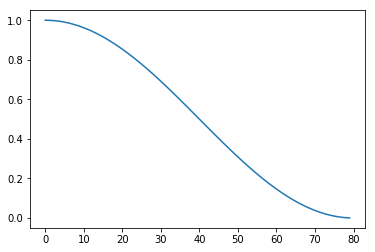

In [25]:
def _cosine_anneal_schedule_check(t):
    cos_inner = np.pi * (t % (epochs))/epochs 
    cos_out = np.cos(cos_inner) + 1
    return 1 / 2 * cos_out

x_info = np.arange(0,epochs)
plt.plot(x_info,_cosine_anneal_schedule_check(x_info))

In [26]:
batch_size=28

snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=0.5e-3)
swa = SWA(model_name+'_swa.model',swa_nb)
valid_im_path,valid_mask_path = './keras_im_val','./keras_mask_val'

# Generators
training_generator = Datagen(augmentation=AUGMENTATIONS_TRAIN,image_size=image_size,batch_size=batch_size)

validation_generator = Datagen(train_dir = VAL_DIR, mask_dir=VAL_MASK_DIR,
                               augmentation=AUGMENTATIONS_TEST, image_size=image_size,batch_size=batch_size)

history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,  
                              use_multiprocessing=False,
                              epochs=epochs,verbose=2,
                              callbacks=snapshot.get_callbacks())

Instructions for updating:
Use tf.cast instead.
Stochastic weight averaging selected for last 5 epochs.
Epoch 1/80
 - 258s - loss: 0.9812 - my_iou_metric: 0.0015 - val_loss: 0.9619 - val_my_iou_metric: 0.0276

Epoch 00001: val_my_iou_metric improved from -inf to 0.02764, saving model to ./Unetplusplusplus_cbam.model
Epoch 2/80
 - 284s - loss: 0.9571 - my_iou_metric: 0.0967 - val_loss: 0.9722 - val_my_iou_metric: 0.5343

Epoch 00002: val_my_iou_metric improved from 0.02764 to 0.53430, saving model to ./Unetplusplusplus_cbam.model
Epoch 3/80
 - 274s - loss: 0.8869 - my_iou_metric: 0.1008 - val_loss: 0.7283 - val_my_iou_metric: 0.5885

Epoch 00003: val_my_iou_metric improved from 0.53430 to 0.58847, saving model to ./Unetplusplusplus_cbam.model
Epoch 4/80
 - 225s - loss: 0.7971 - my_iou_metric: 0.4647 - val_loss: 0.6458 - val_my_iou_metric: 0.7404

Epoch 00004: val_my_iou_metric improved from 0.58847 to 0.74038, saving model to ./Unetplusplusplus_cbam.model
Epoch 5/80
 - 224s - loss: 0.72


Epoch 00044: val_my_iou_metric did not improve from 0.79345
Epoch 45/80
 - 259s - loss: 0.4047 - my_iou_metric: 0.7736 - val_loss: 0.3488 - val_my_iou_metric: 0.7963

Epoch 00045: val_my_iou_metric improved from 0.79345 to 0.79628, saving model to ./Unetplusplusplus_cbam.model
Epoch 46/80
 - 231s - loss: 0.4013 - my_iou_metric: 0.7759 - val_loss: 0.3570 - val_my_iou_metric: 0.7880

Epoch 00046: val_my_iou_metric did not improve from 0.79628
Epoch 47/80
 - 232s - loss: 0.4008 - my_iou_metric: 0.7752 - val_loss: 0.3667 - val_my_iou_metric: 0.7615

Epoch 00047: val_my_iou_metric did not improve from 0.79628
Epoch 48/80
 - 235s - loss: 0.4027 - my_iou_metric: 0.7682 - val_loss: 0.3502 - val_my_iou_metric: 0.7886

Epoch 00048: val_my_iou_metric did not improve from 0.79628
Epoch 49/80
 - 234s - loss: 0.3901 - my_iou_metric: 0.7793 - val_loss: 0.3514 - val_my_iou_metric: 0.7946

Epoch 00049: val_my_iou_metric did not improve from 0.79628
Epoch 50/80
 - 231s - loss: 0.3905 - my_iou_metric: 0

C:\Users\a2720\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in greater


 - 220s - loss: 0.3547 - my_iou_metric: 0.7876 - val_loss: 0.3006 - val_my_iou_metric: 0.8059

Epoch 00072: val_my_iou_metric did not improve from 0.80750
Epoch 73/80
 - 220s - loss: 0.3533 - my_iou_metric: 0.7886 - val_loss: 0.3047 - val_my_iou_metric: 0.8078

Epoch 00073: val_my_iou_metric improved from 0.80750 to 0.80778, saving model to ./Unetplusplusplus_cbam.model
Epoch 74/80
 - 220s - loss: 0.3601 - my_iou_metric: 0.7903 - val_loss: 0.3037 - val_my_iou_metric: 0.8054

Epoch 00074: val_my_iou_metric did not improve from 0.80778
Epoch 75/80
 - 220s - loss: 0.3560 - my_iou_metric: 0.7894 - val_loss: 0.3086 - val_my_iou_metric: 0.8068

Epoch 00075: val_my_iou_metric did not improve from 0.80778
Epoch 76/80
 - 220s - loss: 0.3520 - my_iou_metric: 0.7907 - val_loss: 0.3113 - val_my_iou_metric: 0.8061

Epoch 00076: val_my_iou_metric did not improve from 0.80778
Epoch 77/80
 - 220s - loss: 0.3610 - my_iou_metric: 0.7893 - val_loss: 0.3076 - val_my_iou_metric: 0.8060

Epoch 00077: val_my

Text(0.5, 1.0, 'model loss')

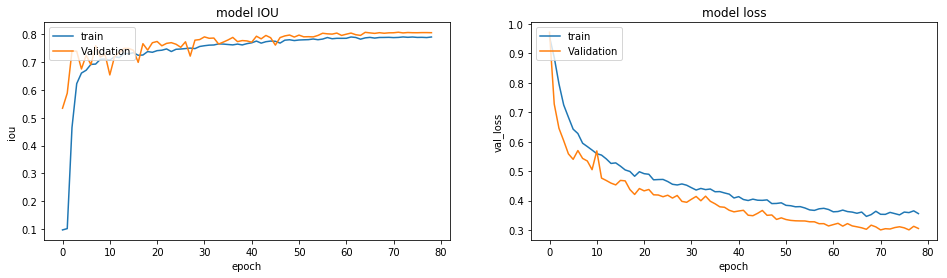

In [27]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model IOU')

plt.subplot(1,2,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')
#gc.collect()

In [28]:
# Load best model or swa model if not available
try:
    print('using swa weight model')
    model.load_weights(model_name+'_swa.model')
except Exception as e:
    print(e)
    model.load_weights(model_name+'.model')

using swa weight model


In [29]:
def predict_result(model,validation_generator,img_size): 
    preds_test1 = model.predict_generator(validation_generator).reshape(-1, img_size, img_size)
    return preds_test1

## Test time augmentation(TTA)
[reference](https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d)


In [30]:
validation_generator = Datagen(train_dir = VAL_DIR, mask_dir = VAL_MASK_DIR,
                               augmentation=AUGMENTATIONS_TEST,
                               image_size=image_size,shuffle=False)

AUGMENTATIONS_TEST_FLIPPED = Compose([
    HorizontalFlip(p=1),
    ToFloat(max_value=1)
],p=1)

validation_generator_flipped = Datagen(train_dir = VAL_DIR, mask_dir=VAL_MASK_DIR,
                                       augmentation=AUGMENTATIONS_TEST_FLIPPED,
                                       image_size=image_size,shuffle=False)

preds_valid_orig = predict_result(model,validation_generator,image_size)
preds_valid_flipped = predict_result(model,validation_generator_flipped,image_size)
preds_valid_flipped = np.array([np.fliplr(x) for x in preds_valid_flipped])
preds_valid = 0.5*preds_valid_orig + 0.5*preds_valid_flipped

In [31]:
len(preds_valid_flipped)

10453

In [32]:
valid_fn = glob.glob('./im_mask_val/*')
len(valid_fn)

10453

In [33]:
valid_fn = glob.glob('./im_mask_val/*')
y_valid_ori = np.array([cv2.resize(np.array(Image.open(fn)),(image_size,image_size)) for fn in valid_fn])
assert y_valid_ori.shape == preds_valid.shape

### IOU threshold selected

This is a trick to get better accuracy/ leaderboard result.  
Cause the output is sigmoid and range[0-1].  
Then we can expected that it would get some FP part with low probility value.  
Therefore, we can setup a threshold to eliminate those part to get better result.  

In [34]:
def cal_iou(y_true_in, y_pred_in):
    smooth = 1e-6
    y_true_in = y_true_in.astype('bool')
    true = np.sum(y_true_in)
    pred = np.sum(y_pred_in)
    intersection = np.sum(y_true_in * y_pred_in)
    union = true + pred - intersection
    iou = (intersection+smooth) / (union+smooth)
    iou = np.floor(max(0, (iou - 0.5)*20)) / 10
    return iou

def cal_iou_metric(y_true_in, y_pred_in):
    metric = []
    for y_t, y_p in zip(y_true_in,y_pred_in):
        metric.append(cal_iou(y_t,y_p))
    return np.mean(metric)

In [35]:
thresholds = np.linspace(0.2, 0.9, 31)
iou_calculated = np.array([cal_iou_metric(y_valid_ori,preds_valid>threshold) for threshold in tqdm_notebook(thresholds)])

### IOU threshold result

Well, it's actually 0.5

14


Text(0.5, 1.0, 'Threshold vs IoU (0.5266666666666666, 0.8110303262221372)')

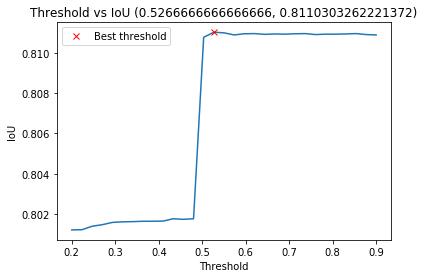

In [36]:
threshold_best_index = np.argmax(iou_calculated) 
print(threshold_best_index)
iou_best = iou_calculated[threshold_best_index]
threshold_best_cal = thresholds[threshold_best_index]

plt.figure()
plt.plot(thresholds,iou_calculated)
plt.plot(threshold_best_cal,iou_best,'xr', label="Best threshold")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best_cal, iou_best))

### Visualize result  

Using validation result to see the predict result

Text(0.5, 0.98, 'Green:Prediction , Red: Pneumothorax.')

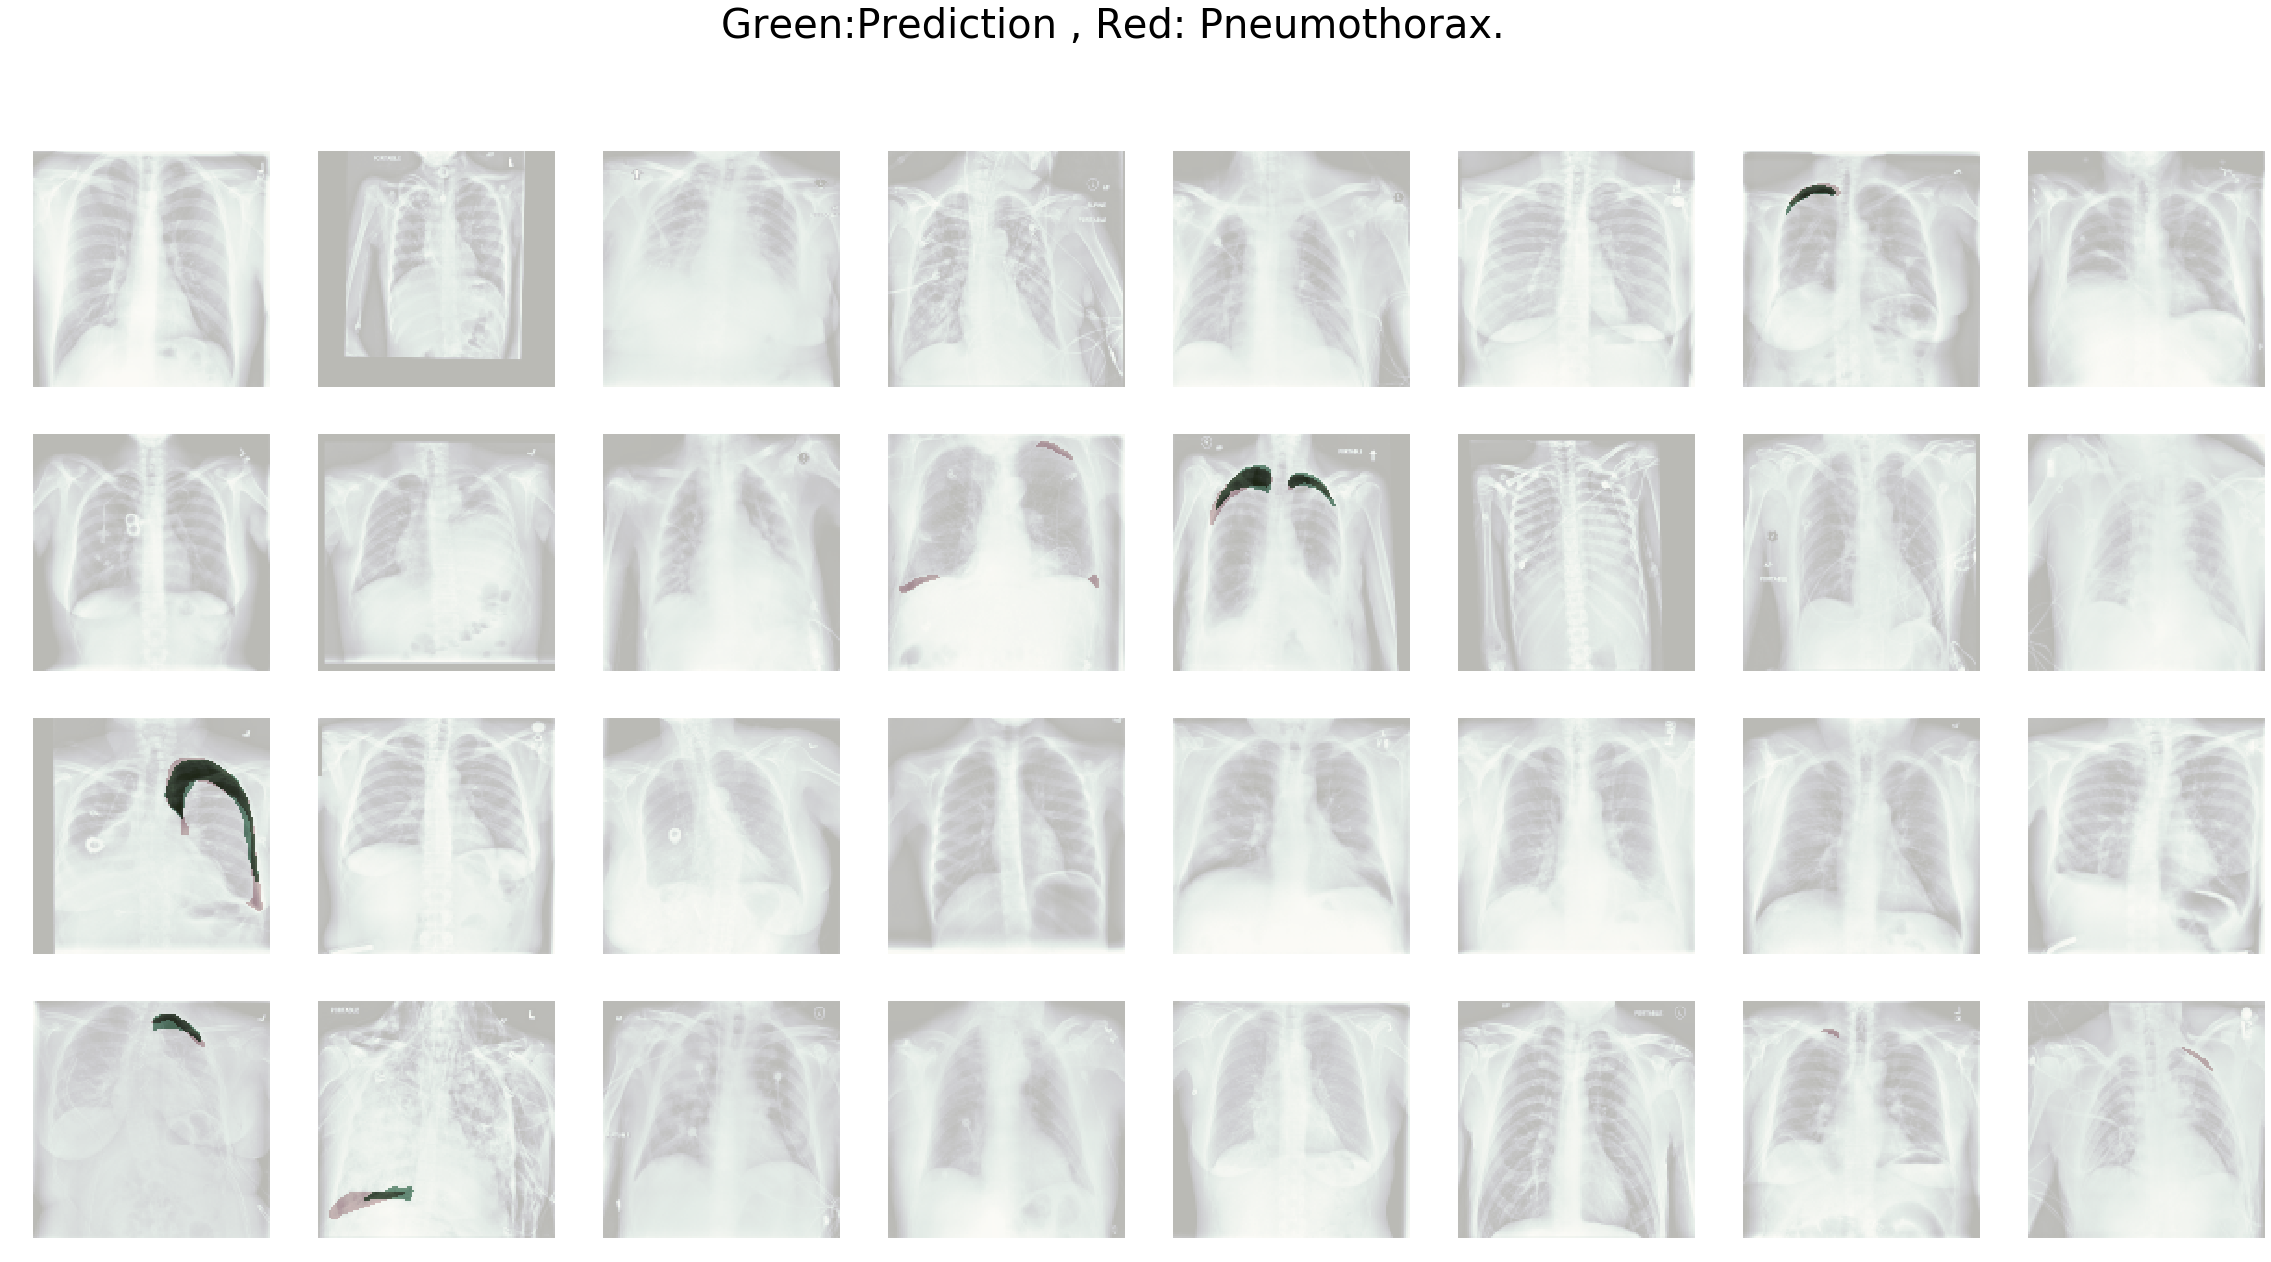

In [37]:
threshold_best = 0.5
max_images = 32
grid_width = 8
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*5, grid_height*5))

validation_generator = Datagen(train_dir = VAL_DIR,
                               mask_dir=VAL_MASK_DIR,augmentation=AUGMENTATIONS_TEST,
                               image_size=image_size,batch_size=max_images,shuffle=False)

images,masks = validation_generator.__getitem__(0)
for i,(im, mask) in enumerate(zip(images,masks)):
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green:Prediction , Red: Pneumothorax.",fontsize = 40)

Text(0.5, 0.98, 'Green:Prediction , Red: Pneumothorax.')

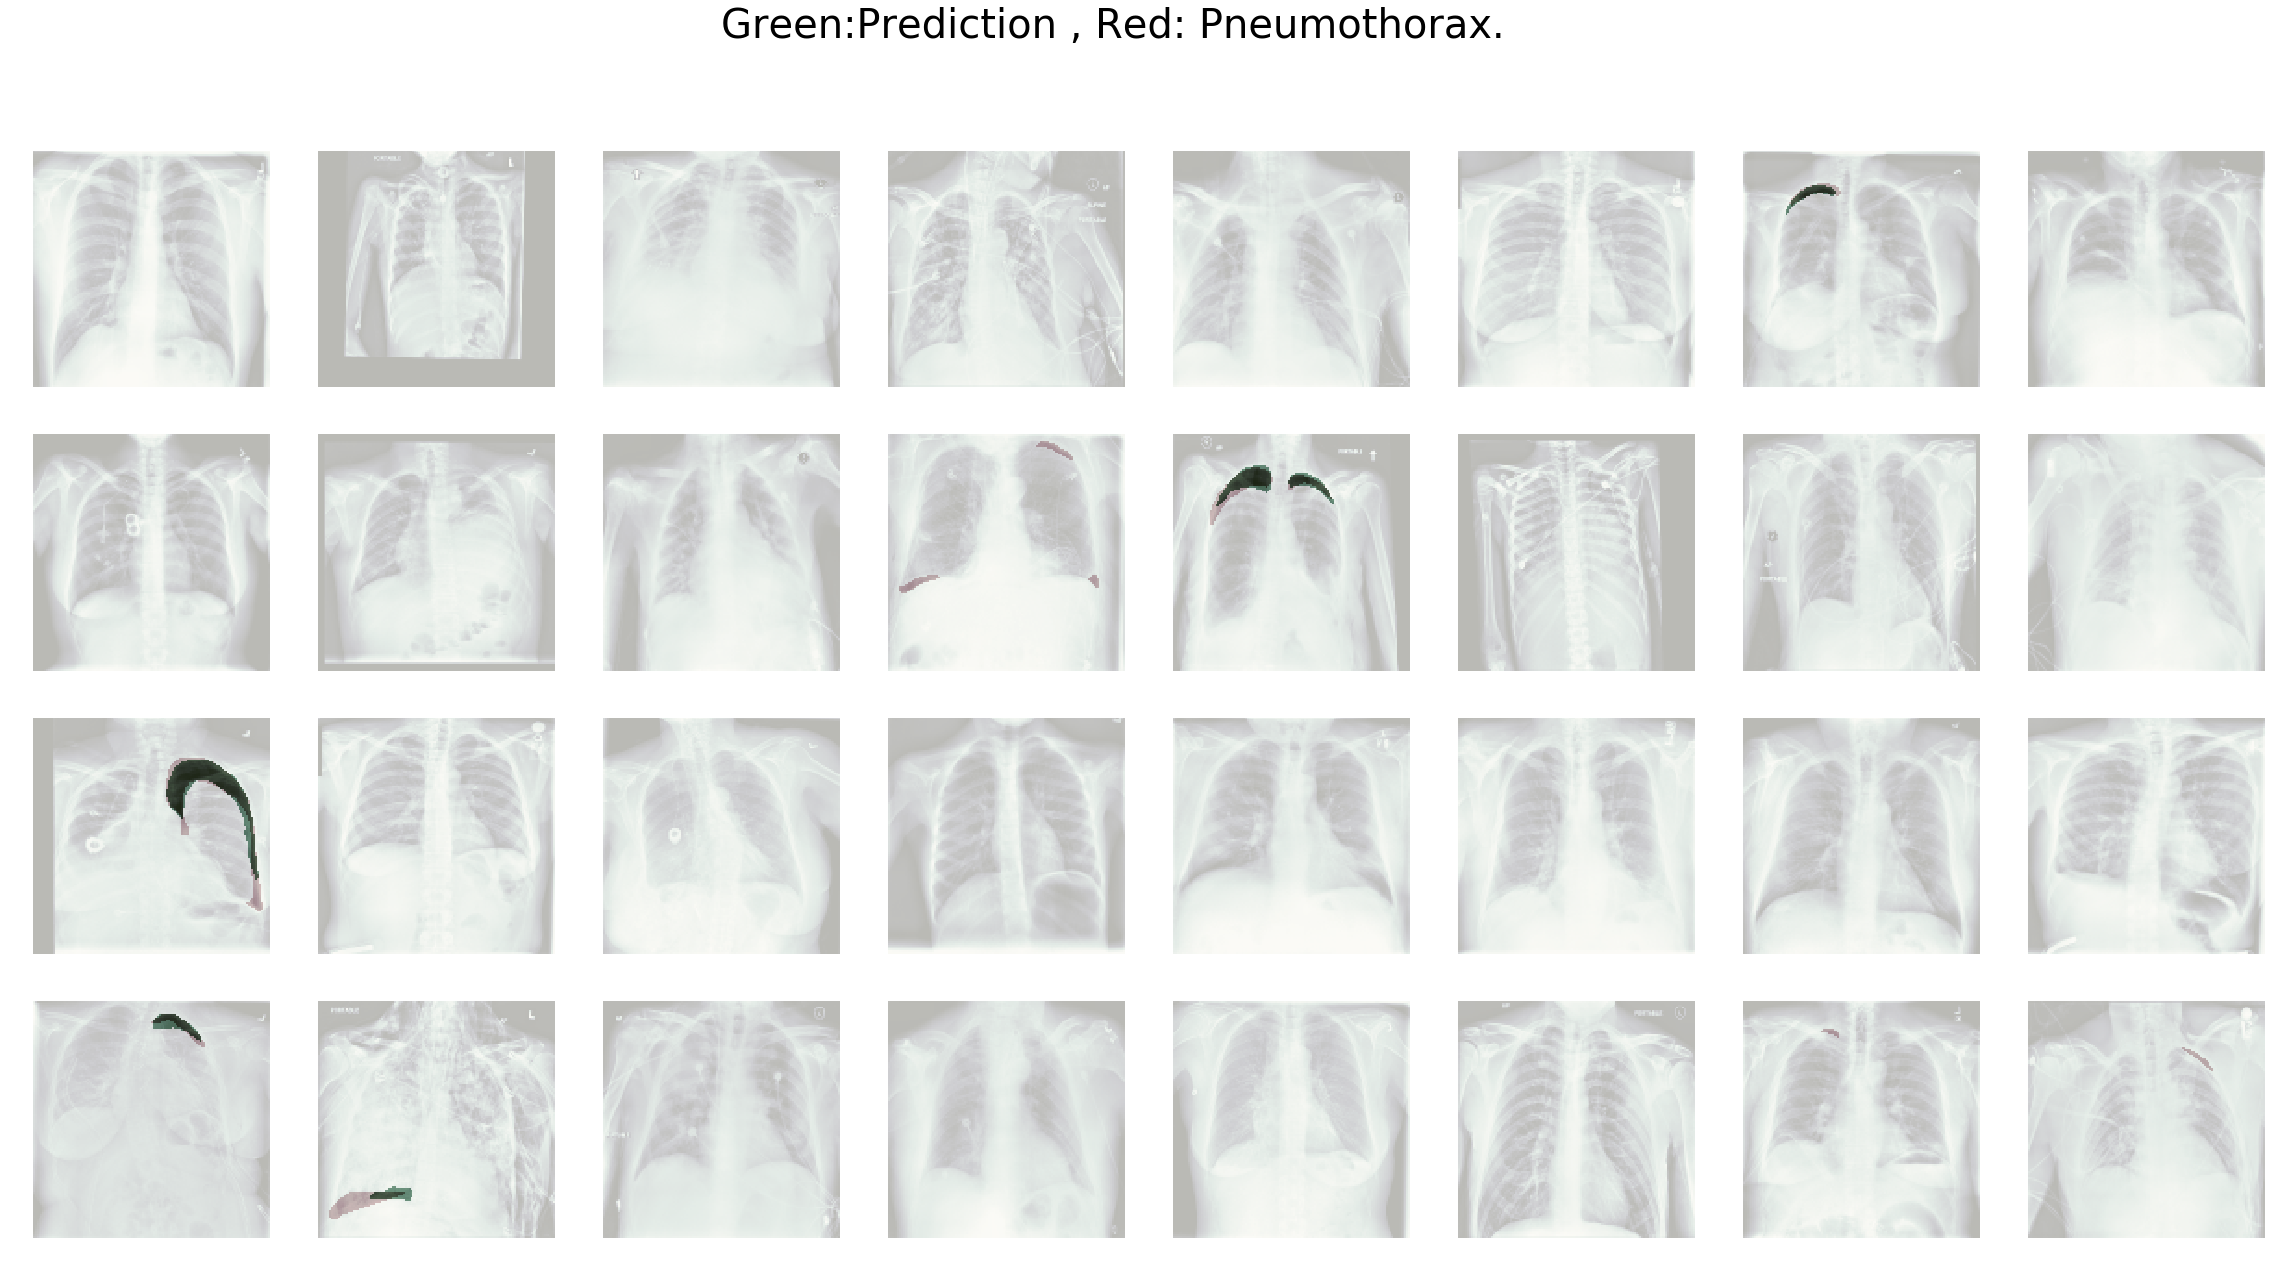

In [38]:
threshold_best = threshold_best_cal
max_images = 32
grid_width = 8
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*5, grid_height*5))

validation_generator = Datagen(train_dir = VAL_DIR,
                               mask_dir=VAL_MASK_DIR,augmentation=AUGMENTATIONS_TEST,
                               image_size=image_size,batch_size=max_images,shuffle=False)

images,masks = validation_generator.__getitem__(0)
for i,(im, mask) in enumerate(zip(images,masks)):
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green:Prediction , Red: Pneumothorax.",fontsize = 40)

In [46]:
test_fn = glob.glob('./results/test/*')
test_img = np.array([cv2.resize(np.array(Image.open(fn)),(image_size,image_size)) for fn in tqdm_notebook(test_fn)])
test_img = np.array([np.repeat(test_img_item[...,None],3,2) for test_img_item in tqdm_notebook(test_img)])
print(test_img.shape)

predict_test = model.predict(test_img,batch_size=batch_size)

test_img_f = np.array([np.fliplr(x) for x in test_img])
preds_test_flipped = model.predict(test_img_f,batch_size=batch_size)
preds_test_flipped = np.array([np.fliplr(x) for x in preds_test_flipped])

predict_test = 0.5*predict_test+0.5*preds_test_flipped


(3205, 128, 128, 3)


Text(0.5, 0.98, 'Green:Prediction , Red: Pneumothorax.')

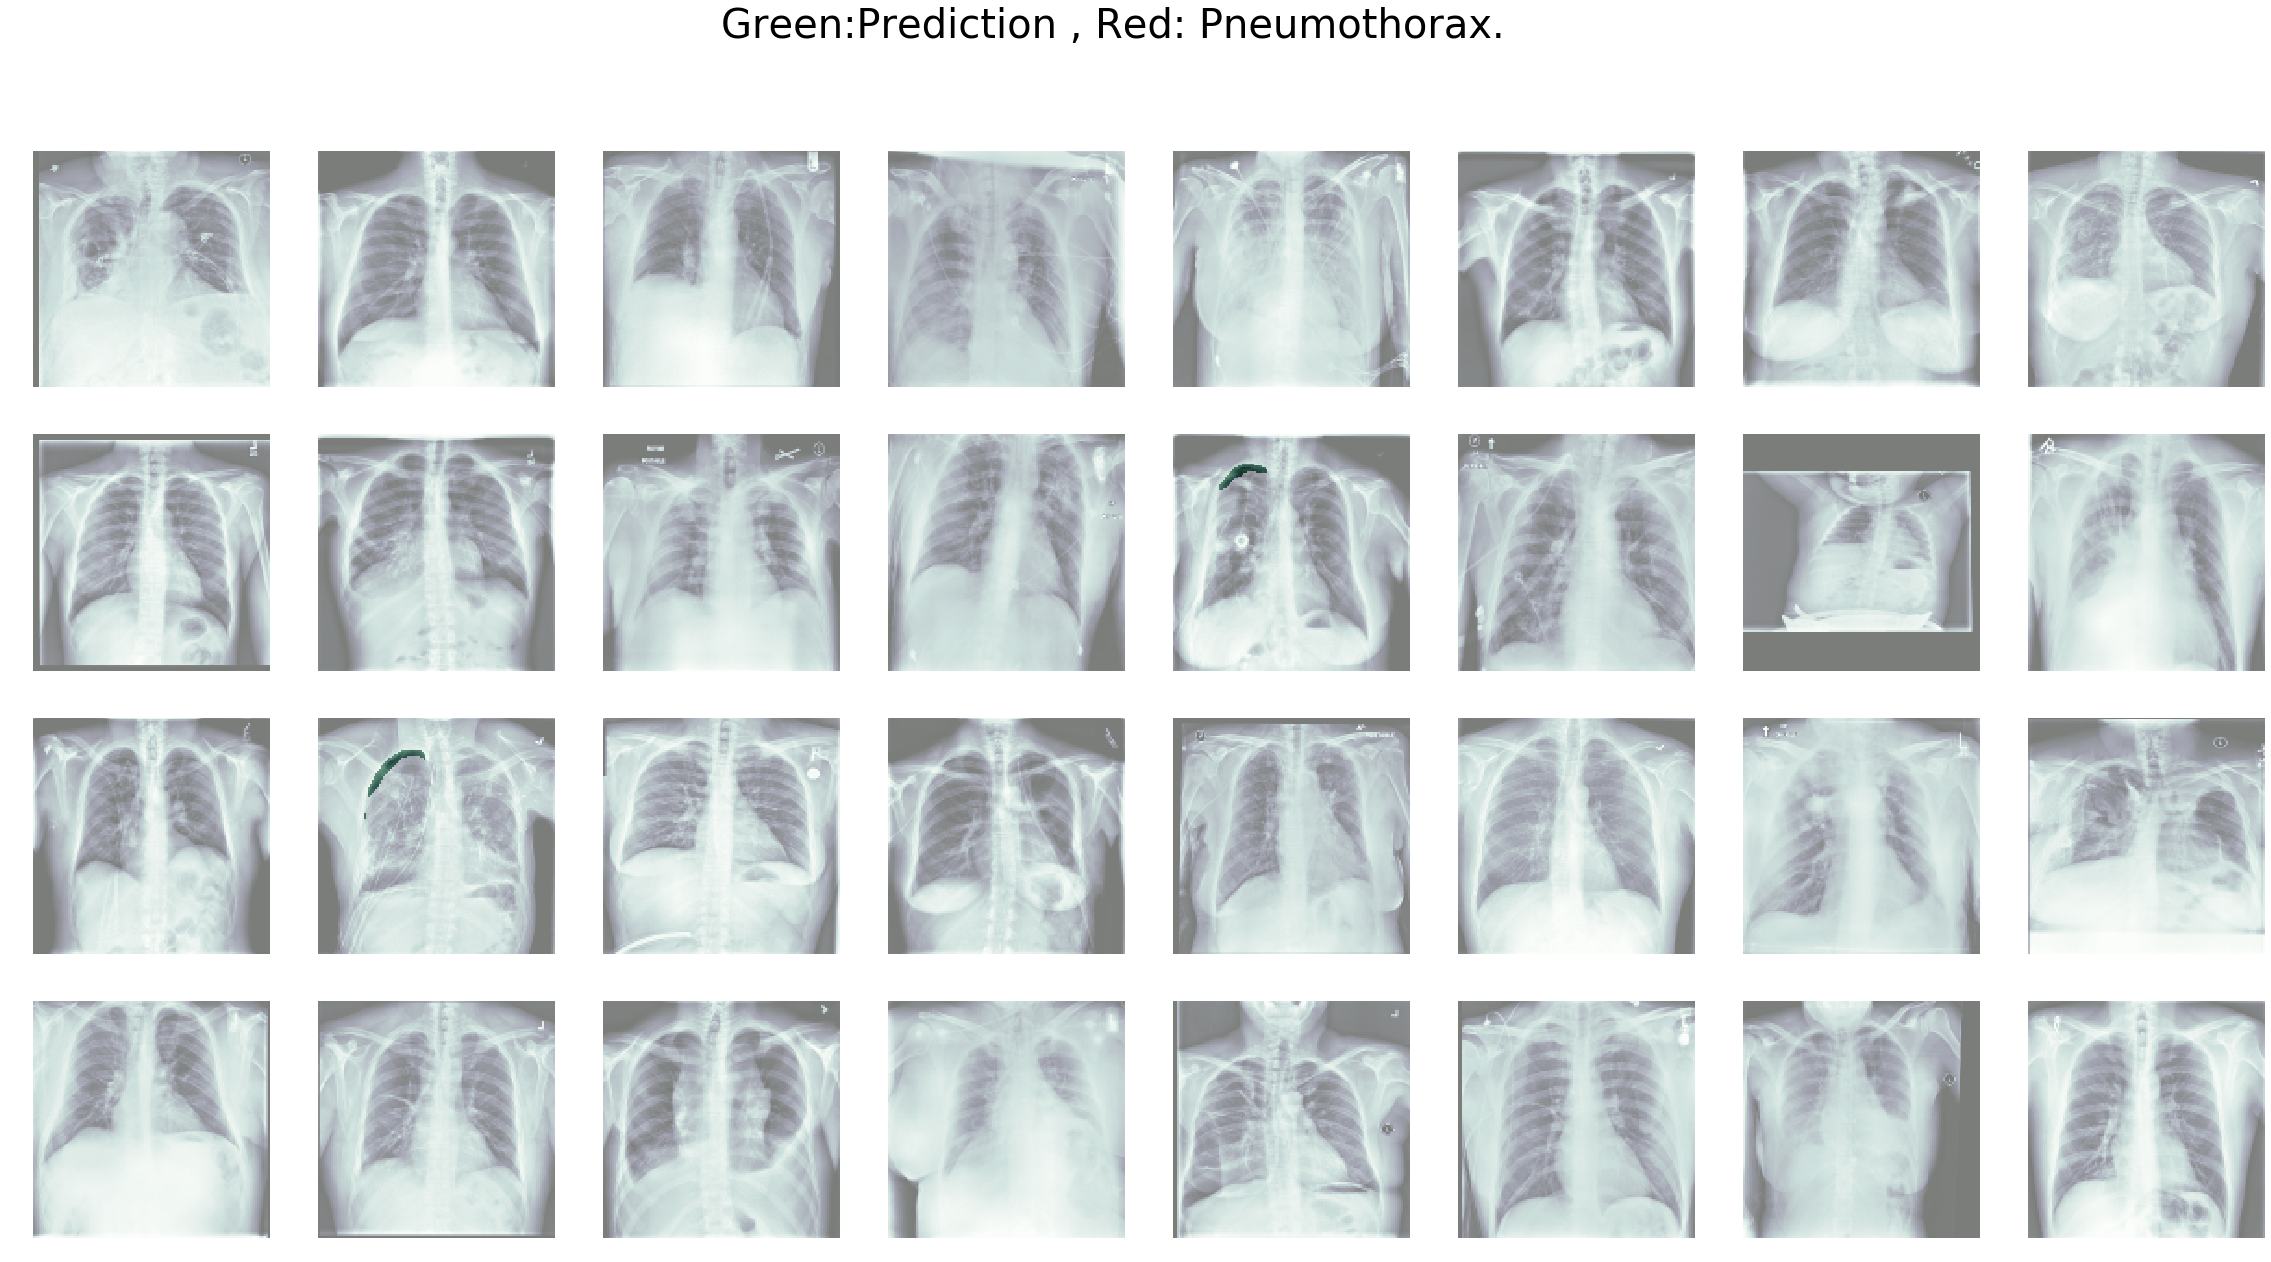

In [47]:
threshold_best = threshold_best_cal
max_images = 32
grid_width = 8
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*5, grid_height*5))

for i in range(max_images):
    pred = predict_test[i].squeeze()   
    im = test_img[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")  
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green:Prediction , Red: Pneumothorax.",fontsize = 40)

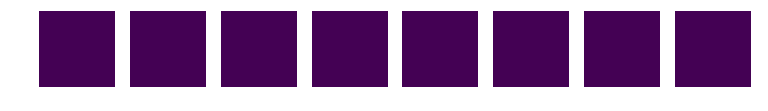

In [48]:
test_result = []
i,max_img = 1,10
plt.figure(figsize=(16,4))
for p in tqdm_notebook(predict_test):
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    im = im > threshold_best
    if im.sum()<1024*2:
        im[:] = 0
    im = (im.T*255).astype(np.uint8)  
    test_result.append(mask2rle(im, 1024, 1024))
    i += 1
    if i<max_img:
        plt.subplot(1,max_img,i)
        plt.imshow(im)
        plt.axis('off')

In [49]:
ids = [id.split('\\')[-1][:-4] for id in test_fn]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': test_result})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head(10)

ImageId EncodedPixels
0  ID_0011fe81e            -1
1  ID_003206608            -1
2  ID_004d6fbb6            -1
3  ID_004d72c54            -1
4  ID_00528aa0e            -1
5  ID_00593ac6d            -1
6  ID_00b0e5a9f            -1
7  ID_00b115bfe            -1
8  ID_00d054471            -1
9  ID_00f04769e            -1

In [50]:
sub_df.to_csv(model_name.split('/')[-1]+'submission.csv', index=False)

### Record result

Using official mask to rle function transfer mask result into csv.  
This competition I get top 14% ranking.   
Result as ensemble kaggle kernel result.  
Just this notebook can not get this leaderboard.  
![](https://imgur.com/eSJuU9n.png)


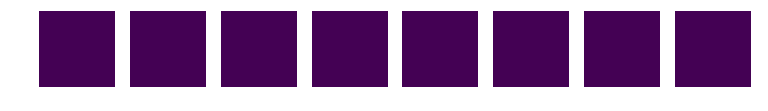

In [51]:
model.load_weights(model_name+'.model')
predict_test = model.predict(test_img,batch_size=batch_size)

test_result = []
i,max_img = 1,10
plt.figure(figsize=(16,4))
for p in tqdm_notebook(predict_test):
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    im = im > threshold_best
    if im.sum()<1024*2:
        im[:] = 0
    im = (im.T*255).astype(np.uint8)  
    test_result.append(mask2rle(im, 1024, 1024))
    i += 1
    if i<max_img:
        plt.subplot(1,max_img,i)
        plt.imshow(im)
        plt.axis('off')

In [52]:
sub_df2 = pd.DataFrame({'ImageId': ids, 'EncodedPixels': test_result})
sub_df2.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df2.head(10)
sub_df2.to_csv(model_name.split('/')[-1]+'_base_submission.csv', index=False)

## Future work   

There are some future work can try:  
* Using higer resolution image to train
* Using ASPP in higher layer to get more semantic segmentation information
* Using public data set combine semi-supervise learning
* Ensemble more model